In [1]:
from itertools import product
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib import pyplot as plt
from collections import defaultdict
import numpy as np
import torch
from torch import nn, autograd
import optimizers
import math
from tqdm import tqdm
np.random.seed(0)
torch.manual_seed(0)

# Configurations

In [2]:
COLORS = ['#7DB1F1', '#FC82AB', '#7FD97B', '#FFC000', '#000000']

# game settings
LR = 0.1
N = 1000
EPS = 0.01

# sample a matrix
A = (torch.eye(N, dtype=torch.float64) + EPS * torch.randn(N, N, dtype=torch.float64)).cuda()
smax = A.svd()[1][0].cpu().numpy()
smin = A.svd()[1][-1].cpu().numpy()
sis = A.svd()[1].cpu().numpy()
print('A conditioning: {}, smax: {}, smin: {}'.format(smax/smin, smax, smin))


def spow(z, k):
    return z ** k

def gd_alt_radius(k, alpha):
    return abs(1- alpha + alpha * spow(
        1 - LR**2 * sis**2 / 2 + LR * sis * np.sqrt(1- LR**2 * sis**2 / 4) * 1j
    , k)).max()


def gd_sim_radius(k, alpha):
    return abs(1 - alpha + alpha * spow(1 + LR * sis * 1j, k)).max()


def pp_sim_radius(k, alpha):
    return abs(1 - alpha + alpha * spow((1+LR*sis*1j)/(1+LR**2*sis**2), k)).max()


def eg_sim_radius(k, alpha):
    return abs(1 - alpha + alpha * spow(1- LR*sis + LR*sis*1j, k)).max()


gd_alt_ro = gd_alt_radius(1, 1)
gd_sim_ro = gd_sim_radius(1, 1)
pp_sim_ro = pp_sim_radius(1, 1)
eg_sim_ro = eg_sim_radius(1, 1)
print(f'gd_alt_ro: {gd_alt_ro}')
print(f'gd_sim_ro: {gd_sim_ro}')
print(f'pp_sim_ro: {pp_sim_ro}')
print(f'eg_sim_ro: {eg_sim_ro}')

A conditioning: 2.5051719389033593, smax: 1.4629746556141772, smin: 0.583981735103817
gd_alt_ro: 1.0
gd_sim_ro: 1.010644818138249
pp_sim_ro: 0.998299175731378
eg_sim_ro: 0.9434110166401143


In [3]:
GD_SIM_BETA1 = 6.09
GD_SIM_BETA2 = 37.514
print(f'GD_SIM BETAS: {GD_SIM_BETA1, GD_SIM_BETA2}')

PP_SIM_BETA1 = 1
PP_SIM_BETA2 = 97.95
print(f'PP_SIM BETAS: {PP_SIM_BETA1, PP_SIM_BETA2}')

EG_SIM_BETA1 = 20.31
EG_SIM_BETA2 = 76.16
print(f'EG_SIM BETAS: {EG_SIM_BETA1, EG_SIM_BETA2}')

C = {
    'GD_SIM': lambda k: min(
        (2 * np.cos(np.angle(1-spow(1+LR*sis*1j, k))) / abs(1-spow(1+LR*sis*1j, k)))
    ),
    'PP_SIM': lambda k: max(
        (
            np.cos(np.angle(1-((1+LR*sis*1j)/(1+LR**2*sis**2))**k)) - 
            np.sqrt(
                1/(1+LR**2*smin**2)**k - 
                np.sin(np.angle(
                    1-spow((1+LR*sis*1j)/(1+LR**2*sis**2), k)
                )) ** 2
            )
        ) /  abs(1-((1+LR*sis*1j)/(1+LR**2*sis**2))**k)
    ),
    'EG_SIM': lambda k:  max(
        (
            np.cos(np.angle(1-spow(1-LR*sis+LR*sis*1j, k))) -
            np.sqrt(
                (1-2*LR*smin+2*LR**2*smin**2)**k -
                np.sin(np.angle(
                    1-spow(1-LR*sis+LR*sis*1j, k)
                )) ** 2
            )
        ) / abs(1-spow(1-LR*sis+LR*sis*1j, k))
    )
}

GD_SIM BETAS: (6.09, 37.514)
PP_SIM BETAS: (1, 97.95)
EG_SIM BETAS: (20.31, 76.16)


# GD_ALT

<ipython-input-4-f6fee4ad5edd>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(


rmin: 0.6418117802935815, rmax: 0.9999999914846447


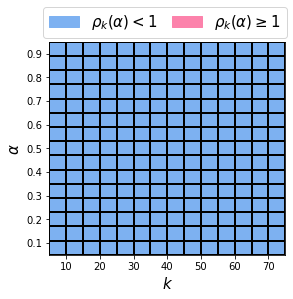

In [4]:
GD_ALT_KS = list(range(5, 80, 5))
GD_ALT_ALPHAS = list(reversed([x/100 for x in range(5, 95 + 1, 90 // 15)]))
GD_ALT_HPS = np.meshgrid(GD_ALT_KS, GD_ALT_ALPHAS)

# compute
gd_alt_radii = np.array([
    gd_alt_radius(k, alpha) for
    (k, alpha) in zip(GD_ALT_HPS[0].flatten(), GD_ALT_HPS[1].flatten())
]).reshape(GD_ALT_HPS[0].shape)

# and plot (matplotlib choses the first color when there is only one value)
cmap = matplotlib.colors.ListedColormap([COLORS[0], COLORS[1]])
plt.figure(figsize=(4, 4))
plt.pcolormesh(
    GD_ALT_HPS[0], GD_ALT_HPS[1], gd_alt_radii < 1, 
    edgecolors='k',
    cmap=cmap,
)
plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$\alpha$', fontsize=15)

#
handles, labels = plt.gca().get_legend_handles_labels()
patch_pos = mpatches.Patch(
    color=COLORS[0], 
    label=r'$\rho_k(\alpha)<1$'
)
patch_neg = mpatches.Patch(
    color=COLORS[1],
    label=r'$\rho_k(\alpha)\geq1$'
)
line_suff = mlines.Line2D([0], [0], color=COLORS[3], label='Thm. 6', linewidth=3)

handles.append(patch_pos) 
handles.append(patch_neg) 
#handles.append(line_suff)

# plot the legend
plt.legend(
    handles=handles, loc='upper center', 
    bbox_to_anchor=(-0.01, 1.20, 1.0, 0), 
    ncol=2, fontsize=15, columnspacing=1,
)
plt.tight_layout(pad=0.1)
plt.savefig('./bilinear_sweep_gd_alt.png', format='png', dpi=200)
print(f'rmin: {gd_alt_radii.min()}, rmax: {gd_alt_radii.max()}')

# GD_SIM

<ipython-input-5-79eac1bd85ae>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(


beta1: 6.09, beta2: 37.514
=> c: [0.7912922703296353, 0.8805040334283156, 0.8993097944210748, 0.8930392790987423, 0.8603330786306569, 0.7689185514601906, 0.4629918667201008, -1.1749286262903889, -3.638956650736324, -4.137990641887426, -4.638074932663175, -5.139347824807506, -5.641375267247767, -6.143891516596959, -6.646947012114167]
=> a: [0.95, 0.89, 0.83, 0.77, 0.71, 0.65, 0.59, 0.53, 0.47, 0.41, 0.35, 0.29, 0.23, 0.17, 0.11, 0.05]
=> k: [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]


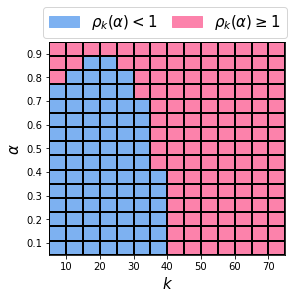

In [5]:
GD_SIM_KS = list(range(5, 80, 5))
GD_SIM_ALPHAS = list(reversed([x/100 for x in range(5, 95 + 1, 90 // 15)]))
GD_SIM_HPS = np.meshgrid(GD_SIM_KS, GD_SIM_ALPHAS)

gd_sim_improvements = np.array([
    1 > gd_sim_radius(k, alpha) for
    (k, alpha) in zip(GD_SIM_HPS[0].flatten(), GD_SIM_HPS[1].flatten())
]).reshape(GD_SIM_HPS[0].shape)
gd_sim_cs = [C['GD_SIM'](k) for k in GD_SIM_KS]

edge_colors = [ ]
cmap = matplotlib.colors.ListedColormap([COLORS[1], COLORS[0]])
plt.figure(figsize=(4, 4))
plt.pcolormesh(
    GD_SIM_HPS[0], GD_SIM_HPS[1], gd_sim_improvements, 
    edgecolors='k',
    cmap=cmap,
)
plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$\alpha$', fontsize=15)

# where some data has already been plotted to ax
handles, labels = plt.gca().get_legend_handles_labels()

# manually define a new patch 
patch_pos = mpatches.Patch(
    color=COLORS[0], 
    label=r'$\rho_k(\alpha)<1$'
)
patch_neg = mpatches.Patch(
    color=COLORS[1],
    label=r'$\rho_k(\alpha)\geq1$'
)
line_suff = mlines.Line2D([0], [0], color=COLORS[3], label='Thm. 7', linewidth=3)

# handles is a list, so append manual patch
handles.append(patch_pos) 
handles.append(patch_neg) 
#handles.append(line_suff)

# plot the legend
plt.legend(
    handles=handles, loc='upper center', 
    bbox_to_anchor=(-0.01, 1.20, 1.0, 0), 
    ncol=2, fontsize=15, columnspacing=1,
)
plt.tight_layout(pad=0.1)
plt.savefig('./bilinear_sweep_gd_sim.png', format='png', dpi=200)
print(f'beta1: {GD_SIM_BETA1}, beta2: {GD_SIM_BETA2}')
print(f'=> c: {gd_sim_cs}')
print(f'=> a: {GD_SIM_ALPHAS}')
print(f'=> k: {GD_SIM_KS}')

# PP_SIM

<ipython-input-6-c87b9cf73d40>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(


=> beta1: 1, beta2: 97.95
=> c: [0.20136786039250618, 0.08069798598520445, 0.054038407564570276, 0.04402563597496977, 0.1074618793654902, 0.2114666490134871, 0.28242476102585523, 0.3632591686497847, 0.45400520323347043, 0.5549581220320206, 0.6672550989793833, 0.7962543581332878, 0.9999999999999906, 0.9999999999999956, 0.9999999999999807]
=> a: [0.95, 0.89, 0.83, 0.77, 0.71, 0.65, 0.59, 0.53, 0.47, 0.41, 0.35, 0.29, 0.23, 0.17, 0.11, 0.05]
=> k: [5, 13, 21, 29, 37, 45, 53, 61, 69, 77, 85, 93, 101, 109, 117]


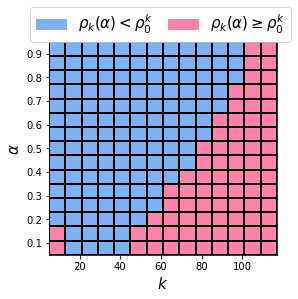

In [6]:
PP_SIM_KS = list(range(5, 120 + 1, 120 // 15))
PP_SIM_ALPHAS = list(reversed([x/1000 for x in range(50, 950 + 1, 900 // 15)]))
PP_SIM_HPS = np.meshgrid(PP_SIM_KS, PP_SIM_ALPHAS)

# compute
pp_sim_improvements = np.array([
    pp_sim_radius(k, 1) > pp_sim_radius(k, alpha) for
    (k, alpha) in zip(PP_SIM_HPS[0].flatten(), PP_SIM_HPS[1].flatten())
]).reshape(PP_SIM_HPS[0].shape)
pp_sim_cs = [C['PP_SIM'](k) for k in PP_SIM_KS]

# and plot
edge_colors = [ ]
cmap = matplotlib.colors.ListedColormap([COLORS[1], COLORS[0]])
plt.figure(figsize=(4, 4))
plt.pcolormesh(
    PP_SIM_HPS[0], PP_SIM_HPS[1], pp_sim_improvements, 
    edgecolors='k',
    cmap=cmap,
)
plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$\alpha$', fontsize=15)

# where some data has already been plotted to ax
handles, labels = plt.gca().get_legend_handles_labels()

# manually define a new patch 
patch_pos = mpatches.Patch(
    color=COLORS[0], 
    label=r'$\rho_k(\alpha)<\rho_0^k$'
)
patch_neg = mpatches.Patch(
    color=COLORS[1],
    label=r'$\rho_k(\alpha)\geq\rho_0^k$'
)
line_suff = mlines.Line2D([0], [0], color=COLORS[3], label='Thm. 8', linewidth=3)

# handles is a list, so append manual patch
handles.append(patch_pos) 
handles.append(patch_neg) 
#handles.append(line_suff)

# plot the legend
plt.legend(
    handles=handles, loc='upper center', 
    bbox_to_anchor=(-0.01, 1.20, 1.0, 0), 
    ncol=2, fontsize=15, columnspacing=1,
)
plt.tight_layout(pad=0.1)
plt.savefig('./bilinear_sweep_pp.png', format='png', dpi=200)
print(f'=> beta1: {PP_SIM_BETA1}, beta2: {PP_SIM_BETA2}')
print(f'=> c: {pp_sim_cs}')
print(f'=> a: {PP_SIM_ALPHAS}')
print(f'=> k: {PP_SIM_KS}')

# EG_SIM

<ipython-input-7-b5ec719c936b>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(


beta1: 20.31, beta2: 76.16
=> c: [0.9999999999999999, 1.0000000000000004, 0.9386372877575877, 0.88189405962177, 0.8538707136828575, 0.8755727534510303, 0.90238232625363, 0.923621131781686, 0.9404464925478963, 0.95377865415444, 0.9643498736793074, 0.9727451081119008, 0.9794374463024417, 0.9848302882829575, 0.9896994732761079, 0.9979913799116246, 1.0000000000000002]
=> a: [0.95, 0.94, 0.93, 0.92, 0.91, 0.9, 0.89, 0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81, 0.8]
=> k: [15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 79]


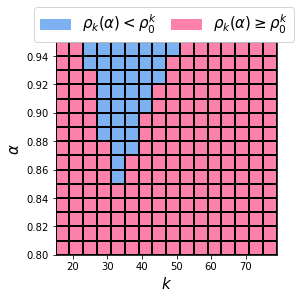

In [7]:
EG_SIM_KS = list(range(15, 80 + 1, 65 // 15))
EG_SIM_ALPHAS = list(reversed([x/1000 for x in range(800, 950 + 1, 150 // 15)]))
EG_SIM_HPS = np.meshgrid(EG_SIM_KS, EG_SIM_ALPHAS)

# compute
eg_sim_improvements = np.array([
    eg_sim_radius(k, 1) > eg_sim_radius(k, alpha) for
    (k, alpha) in zip(EG_SIM_HPS[0].flatten(), EG_SIM_HPS[1].flatten())
]).reshape(EG_SIM_HPS[0].shape)
eg_sim_cs = [C['EG_SIM'](k) for k in EG_SIM_KS]

# plot
edge_colors = [ ]
cmap = matplotlib.colors.ListedColormap([COLORS[1], COLORS[0]])
plt.figure(figsize=(4, 4))
plt.pcolormesh(
    EG_SIM_HPS[0], EG_SIM_HPS[1], eg_sim_improvements, 
    edgecolors='k',
    cmap=cmap,
)
plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$\alpha$', fontsize=15)

# where some data has already been plotted to ax
handles, labels = plt.gca().get_legend_handles_labels()

# manually define a new patch 
patch_pos = mpatches.Patch(
    color=COLORS[0], 
    label=r'$\rho_k(\alpha)<\rho_0^k$'
)
patch_neg = mpatches.Patch(
    color=COLORS[1],
    label=r'$\rho_k(\alpha)\geq\rho_0^k$'
)
line_suff = mlines.Line2D([0], [0], color=COLORS[3], label='Thm. 9', linewidth=3)

# handles is a list, so append manual patch
handles.append(patch_pos) 
handles.append(patch_neg) 
#handles.append(line_suff)

# plot the legend
plt.legend(
    handles=handles, loc='upper center', 
    bbox_to_anchor=(-0.01, 1.20, 1.0, 0), 
    ncol=2, fontsize=15, columnspacing=1
)
plt.tight_layout(pad=0.1)
plt.savefig('bilinear_sweep_eg.png', format='png', dpi=200)
print(f'beta1: {EG_SIM_BETA1}, beta2: {EG_SIM_BETA2}')
print(f'=> c: {eg_sim_cs}')
print(f'=> a: {EG_SIM_ALPHAS}')
print(f'=> k: {EG_SIM_KS}')

<ipython-input-8-f6fee4ad5edd>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(


rmin: 0.6418117802935815, rmax: 0.9999999914846447


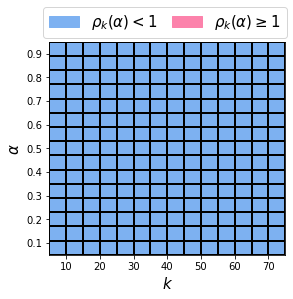

In [8]:
GD_ALT_KS = list(range(5, 80, 5))
GD_ALT_ALPHAS = list(reversed([x/100 for x in range(5, 95 + 1, 90 // 15)]))
GD_ALT_HPS = np.meshgrid(GD_ALT_KS, GD_ALT_ALPHAS)

# compute
gd_alt_radii = np.array([
    gd_alt_radius(k, alpha) for
    (k, alpha) in zip(GD_ALT_HPS[0].flatten(), GD_ALT_HPS[1].flatten())
]).reshape(GD_ALT_HPS[0].shape)

# and plot (matplotlib choses the first color when there is only one value)
cmap = matplotlib.colors.ListedColormap([COLORS[0], COLORS[1]])
plt.figure(figsize=(4, 4))
plt.pcolormesh(
    GD_ALT_HPS[0], GD_ALT_HPS[1], gd_alt_radii < 1, 
    edgecolors='k',
    cmap=cmap,
)
plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$\alpha$', fontsize=15)

#
handles, labels = plt.gca().get_legend_handles_labels()
patch_pos = mpatches.Patch(
    color=COLORS[0], 
    label=r'$\rho_k(\alpha)<1$'
)
patch_neg = mpatches.Patch(
    color=COLORS[1],
    label=r'$\rho_k(\alpha)\geq1$'
)
line_suff = mlines.Line2D([0], [0], color=COLORS[3], label='Thm. 6', linewidth=3)

handles.append(patch_pos) 
handles.append(patch_neg) 
#handles.append(line_suff)

# plot the legend
plt.legend(
    handles=handles, loc='upper center', 
    bbox_to_anchor=(-0.01, 1.20, 1.0, 0), 
    ncol=2, fontsize=15, columnspacing=1,
)
plt.tight_layout(pad=0.1)
plt.savefig('./bilinear_sweep_gd_alt.png', format='png', dpi=200)
print(f'rmin: {gd_alt_radii.min()}, rmax: {gd_alt_radii.max()}')